In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_cardiovasc_baseline'] == 0.0].copy()


    # design_matrix['sofa_cardiovasc_diff2'] = design_matrix['sofa_cardiovasc_day2'] - design_matrix['sofa_cardiovasc_baseline']
    # design_matrix['sofa_cardiovasc_diff3'] = design_matrix['sofa_cardiovasc_day3'] - design_matrix['sofa_cardiovasc_baseline']
    # design_matrix['sofa_cardiovasc_diff1'] = design_matrix['sofa_cardiovasc_day1'] - design_matrix['sofa_cardiovasc_baseline']

    design_matrix['max_cardiovasc_diff'] = np.max(
        design_matrix[
            [
                'sofa_cardiovasc_day1', 
                'sofa_cardiovasc_day2', 
                'sofa_cardiovasc_day3'
            ]
        ], 
        axis=1
    )

    design_matrix['group'] = np.where(
        design_matrix['max_cardiovasc_diff'] > 0, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix       


# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='max_cardiovasc_diff', ylabel='Count'>

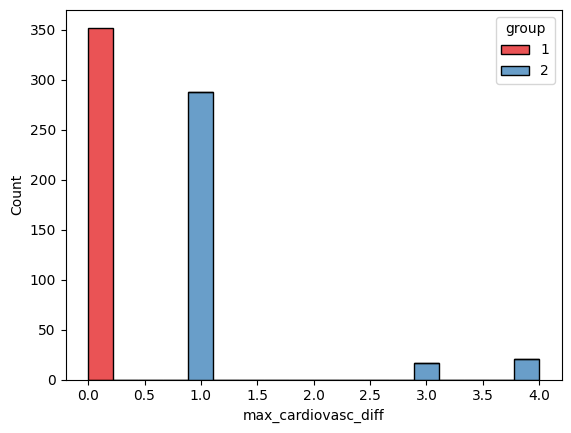

In [7]:
sns.histplot(
    design_matrix_train,
    x="max_cardiovasc_diff",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
1    352
2    326
Name: count, dtype: int64

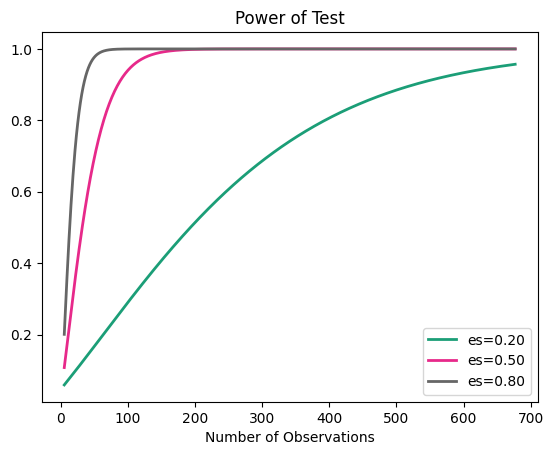

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/cardiovasc_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

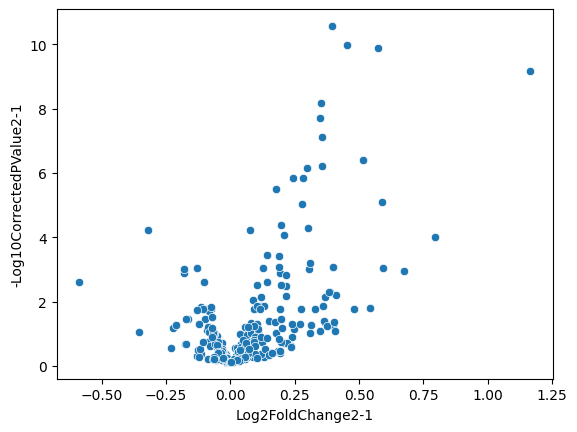

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf,
#     random_state=42
# )

In [21]:
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

label_issues = find_label_issues(
    labels=y.values.ravel(),
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'  # Ranks by likelihood of being mislabeled
)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
mask = np.ones(len(y.values.ravel()), dtype=bool)

mask[label_issues] = False

In [23]:
X = X.iloc[mask, :].copy()
y = y.iloc[mask, :].copy()

In [24]:
y['label'].value_counts()

label
1    203
0    201
Name: count, dtype: int64

In [25]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 1.0049751243781095, 1: 0.9950738916256158}

In [26]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [27]:
len(protein_columns)

287

In [28]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


In [29]:
selected_proteins

['TIMP1_HUMAN',
 'FCN3_HUMAN',
 'VSIG4_HUMAN',
 'ITB3_HUMAN',
 'CYTC_HUMAN',
 'A2GL_HUMAN',
 'PI16_HUMAN',
 'HABP2_HUMAN',
 'IBP7_HUMAN',
 'CATB_HUMAN',
 'B2MG_HUMAN',
 'VWF_HUMAN',
 'A1AT_HUMAN',
 'CFAD_HUMAN',
 'K2C1_HUMAN',
 'LYSC_HUMAN',
 'PTGDS_HUMAN',
 'CNDP1_HUMAN',
 'NCAM1_HUMAN',
 'IBP2_HUMAN',
 'VCAM1_HUMAN',
 'A2AP_HUMAN',
 'SODC_HUMAN',
 'CAMP_HUMAN',
 'MRC1_HUMAN',
 'CD44_HUMAN',
 'TENA_HUMAN',
 'SEPP1_HUMAN',
 'CO6A3_HUMAN',
 'PLTP_HUMAN',
 'CFAB_HUMAN',
 'COIA1_HUMAN',
 'ADIPO_HUMAN',
 'PROZ_HUMAN',
 'CMGA_HUMAN',
 'NRP1_HUMAN',
 'C163A_HUMAN',
 'K22E_HUMAN',
 'FETUB_HUMAN',
 'NCHL1_HUMAN',
 'CD14_HUMAN',
 'SAA4_HUMAN',
 'VASN_HUMAN',
 'SHBG_HUMAN',
 'SODE_HUMAN',
 'PLMN_HUMAN',
 'THIO_HUMAN',
 'RNAS4_HUMAN',
 'ICAM2_HUMAN',
 'CRP_HUMAN']

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7535850160959906,
 0.7282984282984284,
 0.7351575456053068,
 0.7350014632718759)

In [32]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [33]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [34]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [35]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
5,A2GL_HUMAN,0.996611,2.0,1.000000,1.0,1.000000,1.0,0.810412,3.0,1.000000,...,1.000000,1.0,1.000000,1.0,0.964268,1.000000,0.105515,1.41,1.0,1.356578
20,VCAM1_HUMAN,0.534708,6.0,0.529608,7.0,0.725597,2.0,0.961889,2.0,0.524368,...,0.435798,9.0,0.711354,3.0,0.637981,0.657847,0.234912,6.45,4.0,7.452713
2,VSIG4_HUMAN,0.783948,4.0,0.292871,19.0,0.382434,6.0,0.672354,6.0,0.459621,...,0.494055,6.0,0.729981,2.0,0.614833,0.628692,0.190914,5.51,4.0,3.807210
7,HABP2_HUMAN,0.993451,3.0,0.421829,11.0,0.338855,8.0,1.000000,1.0,0.387277,...,0.403706,10.0,0.487024,7.0,0.589572,0.572818,0.207821,6.74,5.0,6.515901
45,PLMN_HUMAN,1.000000,1.0,0.259979,23.0,0.517365,4.0,0.438683,10.0,0.510164,...,0.474601,7.0,0.100131,39.0,0.542963,0.538872,0.190911,7.96,6.0,7.178700
23,CAMP_HUMAN,0.389487,9.0,0.568955,4.0,0.148874,27.0,0.257650,27.0,0.352752,...,0.378893,11.0,0.492099,6.0,0.449845,0.427815,0.164902,10.50,9.0,6.439305
49,CRP_HUMAN,0.357720,12.0,0.404333,12.0,0.160738,23.0,0.381034,16.0,0.567329,...,0.692994,2.0,0.510612,5.0,0.376307,0.369190,0.214795,16.57,11.5,13.510381
3,ITB3_HUMAN,0.336157,15.0,0.252971,24.0,0.236632,15.0,0.690319,5.0,0.312425,...,0.298548,17.0,0.244743,20.0,0.371258,0.349551,0.164776,15.25,13.0,10.139806
26,TENA_HUMAN,0.476608,7.0,0.369092,15.0,0.238085,14.0,0.336103,18.0,0.328469,...,0.328926,13.0,0.417825,8.0,0.347907,0.330039,0.132040,15.28,13.0,7.995049
9,CATB_HUMAN,0.317275,19.0,0.251725,25.0,0.645730,3.0,0.153966,34.0,0.277542,...,0.521833,5.0,0.208903,27.0,0.347788,0.336351,0.167473,16.95,16.0,10.540327


In [36]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [37]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [38]:
selected_features = selected_proteins[:10]

In [39]:
for feature in selected_features:

    print(feature)

A2GL_HUMAN
VCAM1_HUMAN
VSIG4_HUMAN
HABP2_HUMAN
PLMN_HUMAN
CAMP_HUMAN
CRP_HUMAN
ITB3_HUMAN
TENA_HUMAN
CATB_HUMAN


In [40]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [41]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7683640620427276, 0.7802683415501678, 0.774663718444813, 0.7747292947029557)

In [42]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.8421861281826164, 0.872365869424693, 0.8588538787543764, 0.8589040093649399)

In [43]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [44]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [45]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [46]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,A2GL_HUMAN,0.586489,4.0,0.891707,3.0,1.000000,1.0,0.953799,2.0,1.000000,...,1.000000,1.0,1.000000,1.0,0.863428,0.919097,0.167650,2.33,2.0,1.570273
3,HABP2_HUMAN,1.000000,1.0,0.975951,2.0,0.867046,3.0,1.000000,1.0,0.462092,...,0.749966,5.0,0.624586,5.0,0.857953,0.923310,0.157870,2.42,2.0,1.436747
2,VSIG4_HUMAN,0.807318,2.0,1.000000,1.0,0.493120,6.0,0.844909,4.0,0.647028,...,0.845025,3.0,0.855886,3.0,0.826242,0.844967,0.157413,2.51,2.0,1.290955
4,PLMN_HUMAN,0.633101,3.0,0.364310,10.0,0.569435,5.0,0.535094,7.0,0.375659,...,0.584340,7.0,0.414278,7.0,0.583173,0.618352,0.158650,5.43,5.0,1.804904
5,CAMP_HUMAN,0.418176,5.0,0.783185,4.0,0.327146,7.0,0.544031,6.0,0.359282,...,0.768428,4.0,0.931455,2.0,0.552144,0.550139,0.165154,5.71,6.0,1.945183
9,CATB_HUMAN,0.417807,6.0,0.461423,9.0,0.919351,2.0,0.456283,8.0,0.566279,...,0.897383,2.0,0.300140,9.0,0.545041,0.523830,0.197895,5.87,6.0,2.334004
7,ITB3_HUMAN,0.269480,8.0,0.751674,5.0,0.250130,9.0,0.948916,3.0,0.555261,...,0.491154,8.0,0.430768,6.0,0.532218,0.519748,0.164300,6.02,6.0,1.711400
6,CRP_HUMAN,0.241502,9.0,0.563028,6.0,0.574623,4.0,0.587939,5.0,0.817005,...,0.644104,6.0,0.678760,4.0,0.464449,0.483249,0.169627,6.83,7.0,2.030351
8,TENA_HUMAN,0.280258,7.0,0.532983,7.0,0.312351,8.0,0.194850,9.0,0.331575,...,0.361984,9.0,0.337391,8.0,0.342035,0.333983,0.102634,8.36,9.0,0.904757
1,VCAM1_HUMAN,0.192218,10.0,0.526341,8.0,0.010571,10.0,0.084938,10.0,0.114630,...,0.095452,10.0,0.104122,10.0,0.168521,0.138683,0.131376,9.52,10.0,1.086929


In [47]:
final_protein_importances.to_csv(
    "feature_importances/cardiovasc_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [48]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [49]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [50]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [51]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [52]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [53]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [54]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

# lr_clf = BaggingClassifier(
#     estimator=lr_clf,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)


In [55]:
lr_clf.fit(X[selected_features], y.values.ravel()), #)
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [56]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [57]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.576271186440678,
 0.6080246913580247,
 0.5710014947683109,
 0.5915492957746479,
 0.5822784810126582,
 0.5590062111801242,
 0.6123595505617978,
 0.5924812030075188)

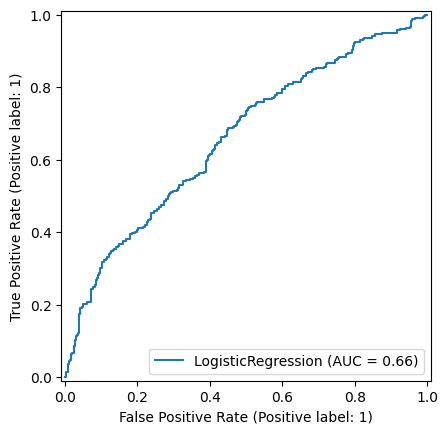

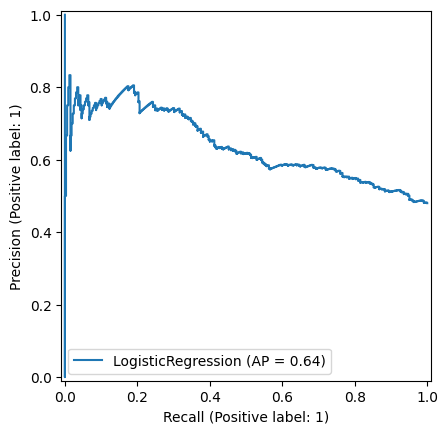

In [58]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [59]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [60]:
roc_df.to_csv(
    "roc/cardiovasc.tsv",
    sep="\t"
)

# Probability Prediction

In [61]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [62]:
predict_data = predict_data[protein_columns].copy()

In [63]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [64]:
predict_data['cardiovasc_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [65]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['cardiovasc_probability']
).reset_index()

In [66]:
predict_data[['cardiovasc_probability']].to_csv(
    "predictions_test/cardiovasc.tsv",
    sep="\t"
)

<Axes: xlabel='cardiovasc_probability', ylabel='Count'>

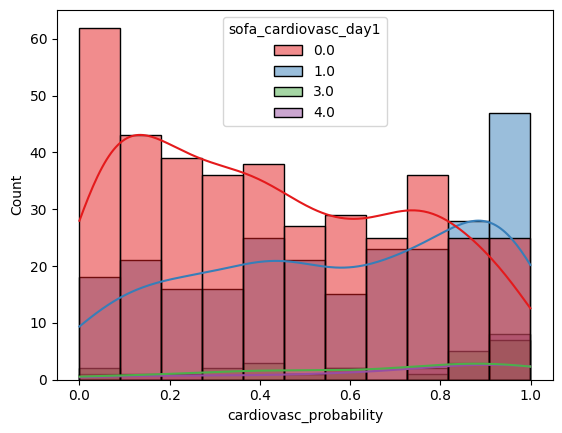

In [67]:
sns.histplot(
    data=design_matrix_test,
    x="cardiovasc_probability",
    hue="sofa_cardiovasc_day1",
    palette="Set1", 
    kde=True,
    #multiple="stack"
)

In [68]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [69]:
val_data = val_data[protein_columns].copy()

In [70]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [71]:
val_data['cardiovasc_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [72]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['cardiovasc_probability']
).reset_index()

In [73]:
val_data[['cardiovasc_probability']].to_csv(
    "predictions_val/cardiovasc.tsv",
    sep="\t"
)

<Axes: xlabel='cardiovasc_probability', ylabel='Count'>

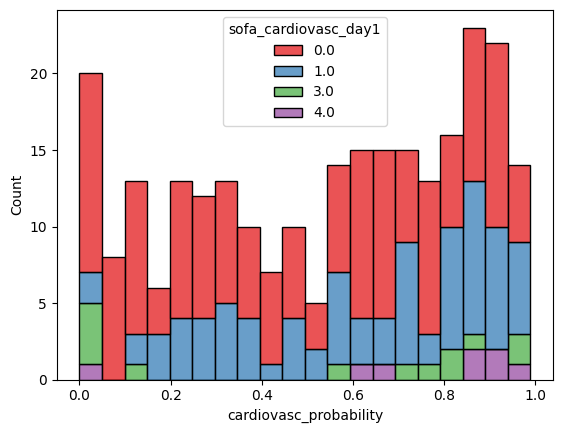

In [74]:
sns.histplot(
    data=design_matrix_val,
    x="cardiovasc_probability",
    hue="sofa_cardiovasc_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [75]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [76]:
hero_data = hero_data[protein_columns].copy()

In [77]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [78]:
hero_data['cardiovasc_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [79]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['cardiovasc_probability']
).reset_index()

In [80]:
hero_data[['cardiovasc_probability']].to_csv(
    "predictions_external/cardiovasc.tsv",
    sep="\t"
)

<Axes: xlabel='cardiovasc_probability', ylabel='Count'>

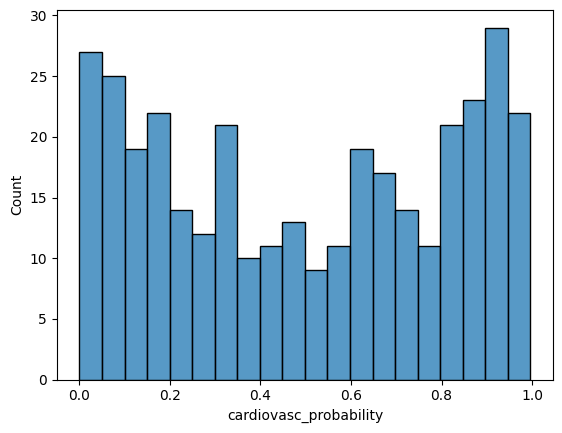

In [81]:
sns.histplot(
    data=hero_data,
    x="cardiovasc_probability",
    #hue="sofa_cardiovasc_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [82]:
from joblib import dump


with open("models/cardiovasc_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/cardiovasc_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
